# Installing dependencies

In [1]:
!pip install node2vec
!pip install pycountry

import logging
logging.getLogger("sentence_transformers").setLevel(logging.WARNING)
logging.getLogger("transformers").setLevel(logging.ERROR)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 40.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompat

In [2]:
speech = "Free market is an economic system based purely on supply and demand. This quintessential system however is used as a disguise to hide corruption and crony capilaism. It is used to hide a system where companies benefit not from free enterprise but from their relation with the government. Under this disguise of economic liberalization, governments privatize their companies unfairly with low prices, exclusive contracts, and regulatory capture. Corruption in privatization processes undermines economic stability, erodes public trust, and distorts the principles of free market economies. During privatization, government officials may be compelled to give unfair advantages to companies beneficial for themselves. By promoting stock holding disclosure and facilitating random audits, we can improve transparency within nations undergoing significant change. Promoting transparency in crucial in ensuring that privatization happens fairly. Transparency in privatization isn’t just a moral imperative; it is essential in attracting foreign investment and ensuring sustainable economic growth. A vote for this directive is a vote to uphold the values of free market during this critical period of economic transformation"

# Policy Embeddings
In this notebook, I vectorized each nation's political stance by:
- cleaning text
- embedding country speeches with semantic segmentation and averaging
- graph based knowledge embedding utilzied country information such as: political bloc, voting record
- combining vectors

# Cleaning Text

In [3]:
# Function for cleaning data
import re
def clean_text(text: str) -> str:
    """Clean text by removing country names while preserving stopwords"""

    country_names = [
        "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", 
        "Antigua", "Argentina", "Armenia", "Australia", "Austria",
        "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados",
        "Belarus", "Belgium", "Belize", "Benin", "Bhutan",
        "Bolivia", "Bosnia", "Botswana", "Brazil", "Brunei",
        "Bulgaria", "Burkina", "Burundi", "Cambodia", "Cameroon",
        "Canada", "Cape Verde", "Central African Republic", "Chad", "Chile",
        "China", "Colombia", "Comoros", "Congo", "Costa Rica",
        "Croatia", "Cuba", "Cyprus", "Czech Republic", "Denmark",
        "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt",
        "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini",
        "Ethiopia", "Fiji", "Finland", "France", "Gabon",
        "Gambia", "Georgia", "Germany", "Ghana", "Greece",
        "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana",
        "Haiti", "Honduras", "Hungary", "Iceland", "India",
        "Indonesia", "Iran", "Iraq", "Ireland", "Israel",
        "Italy", "Ivory Coast", "Jamaica", "Japan", "Jordan",
        "Kazakhstan", "Kenya", "Kiribati", "Korea", "Kosovo",
        "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon",
        "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania",
        "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives",
        "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius",
        "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia",
        "Montenegro", "Morocco", "Mozambique", "Myanmar", "Namibia",
        "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua",
        "Niger", "Nigeria", "North Korea", "North Macedonia", "Norway",
        "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea",
        "Paraguay", "Peru", "Philippines", "Poland", "Portugal",
        "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts",
        "Saint Lucia", "Saint Vincent", "Samoa", "San Marino", "Sao Tome",
        "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone",
        "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia",
        "South Africa", "South Korea", "South Sudan", "Spain", "Sri Lanka",
        "Sudan", "Suriname", "Sweden", "Switzerland", "Syria",
        "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Timor-Leste",
        "Togo", "Tonga", "Trinidad", "Tunisia", "Turkey",
        "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates",
        "United Kingdom", "United States", "Uruguay", "Uzbekistan", "Vanuatu",
        "Vatican City", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"
    ]
    
    country_names += [
        "USA", "UK", "UAE", "PRC", "DPRK", 
        "ROK", "DRC", "U.S.", "U.K.", "America",
        "Britain", "England", "Scotland", "Wales", "Northern Ireland",
        "Hong Kong", "Macau", "Palestine", "Ivory Coast", "Czechia",
        "Macedonia", "Swaziland", "Burma", "East Timor", "Vatican"
    ]
    text = re.sub(r'\b(?:the\s+)?(?:delegation\s+of\s+)?(?:representative\s+of\s+)?(' + 
                  '|'.join(country_names) + r')\b', '[COUNTRY]', text, flags=re.IGNORECASE)
    
    text = re.sub(r'[^\w\s\[\]]', ' ', text) 
    text = text.lower()

    text = ' '.join(text.split()).strip()
    
    return text[:3000]

# Semantic Segmentation using GPT 4o

In [4]:
import json
def get_segments(text: str, max_tokens = 200) -> list[str]:
    paragraphs = [p for p in text.split('\n') if p.split()]

    num_seg = max(0, len(text.split())//max_tokens) + 3
    print(f"Num segments: {num_seg}")
    system =     system = f"""
    You will do semantic segmentation of the following text and output the result as a JSON string.
    Segment this diplomatic text into {num_seg} coherent policy segments.
    Each segment should focus on a single policy theme (e.g., economic policy, 
    security concerns, human rights, international cooperation).
    Preserve diplomatic context and policy coherence within each segment.
    
    Return the result as JSON with this exact format:
    {{"segments": ["segment1", "segment2", "segment3"]}}
    """
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": speech}
        ],
        response_format={"type": "json_object"}
    )
    
    segments = json.loads(response.choices[0].message.content)["segments"]
    if not len(paragraphs) == 1:
        segments.append(paragraphs)
    segments.append(text)
    print(f"Generated {len(segments)} segments. ")
    return segments

In [5]:
import pandas as pd
from kaggle_secrets import UserSecretsClient
from openai import AzureOpenAI
import os
from openai import OpenAI

user_secrets = UserSecretsClient()

api = user_secrets.get_secret("OPENAI_API_KEY")
client = AzureOpenAI(
    api_key=api,
    api_version="2024-11-01-preview",
    azure_endpoint="https://swedencentral.api.cognitive.microsoft.com"
)

# Ensemble Embeddings using text-embedding-3-large & bge-large-en-v1.5

In [6]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
import numpy as np

def generate_embeddings(texts: list[str]):
    stm = SentenceTransformer('BAAI/bge-large-en-v1.5')
    embeddings = []
    for i in texts:
        bge = stm.encode(i)
        response = client.embeddings.create(
            model="text-embedding-3-large",
            input=i
        )
        emb1 = normalize([response.data[0].embedding])[0]
        emb2 = normalize([bge])[0]
        embedding = np.concatenate([emb1, emb2])
        embeddings.append(embedding)
    
    fin_emb = []
    
    for i in range(len(embeddings)):
        fin_emb.append(list(embeddings[i]))
    return fin_emb

texts = get_segments(speech)
embeddings = generate_embeddings(texts)
print(len(embeddings))

2025-06-19 01:41:51.758068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750297312.001193      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750297312.068200      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num segments: 3
Generated 4 segments. 


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

4


# Knowledge injecting using node graphs

# Generating embeddings for every country speech

In [7]:
import pycountry
data = pd.read_csv("/kaggle/input/un-general-debates/un-general-debates.csv")
data = data.drop(columns=['session', 'year'])

code_to_country = {country.alpha_3: country.name for country in pycountry.countries}

data['country'] = data['country'].map(code_to_country)
data.head()

,country,text
0,Maldives,﻿It is indeed a pleasure for me and the member...
1,Finland,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,Niger,"﻿\nMr. President, it is a particular pleasure ..."
3,Uruguay,﻿\nDuring the debate at the fortieth session o...
4,Zimbabwe,﻿I should like at the outset to express my del...


## Generated Embeddings:

In [8]:
df = pd.read_csv("/kaggle/input/better-speech-embeddings/country_embeddings_optimized.csv").transpose()
df2 = pd.read_csv("/kaggle/input/2-hour-speech-embedding-average-5200-speeches/my_file.csv")
df.columns = df2.columns
df.drop('Unnamed: 0', inplace=True)
df.index = range(0, 4096)

In [9]:
import networkx as nx
from itertools import combinations
from node2vec import Node2Vec

import pandas as pd

IGO = pd.read_csv("/kaggle/input/political-igos/Major Political IGOs Expanded.csv")
IGO["Member Countries"] = IGO["Member Countries"].apply(lambda x: str(x.split("; ")))

organizations = {IGO.iloc[i]['IGO Name'] : IGO.iloc[i]['Member Countries'] for i in range(len(IGO))}

In [10]:
import ast

# Convert stringified lists into actual lists
for k in organizations:
    if isinstance(organizations[k], str):
        organizations[k] = ast.literal_eval(organizations[k])


del organizations['United Nations (UN)']

In [11]:
voting = pd.read_csv("/kaggle/input/un-grouped-voting-data/Voting Data Groupings.csv")
voting["countries"] = voting["countries"].fillna('')
voting["countries"] = voting["countries"].apply(lambda x: x.split(";") if x else [])

votings = {voting.iloc[i]['resolution'] : voting.iloc[i]['countries'] for i in range(len(voting))}

In [39]:
from collections import Counter

edge_counter = Counter()

for org_name, members in organizations.items():
    org_weight = 10 / len(members)
    for pair in combinations(members, 2):
        edge_counter[pair] += org_weight
for members in votings.values():
    for pair in combinations(members, 2):
        edge_counter[pair] += 1

G = nx.Graph()
for (u, v), w in edge_counter.items():
    G.add_edge(u, v, weight=w)

node2vec = Node2Vec(G, dimensions=128, walk_length=40, num_walks=300, 
                    p=1, q=0.25, weight_key='weight', workers=2)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/200 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 150/150 [00:34<00:00,  4.30it/s]


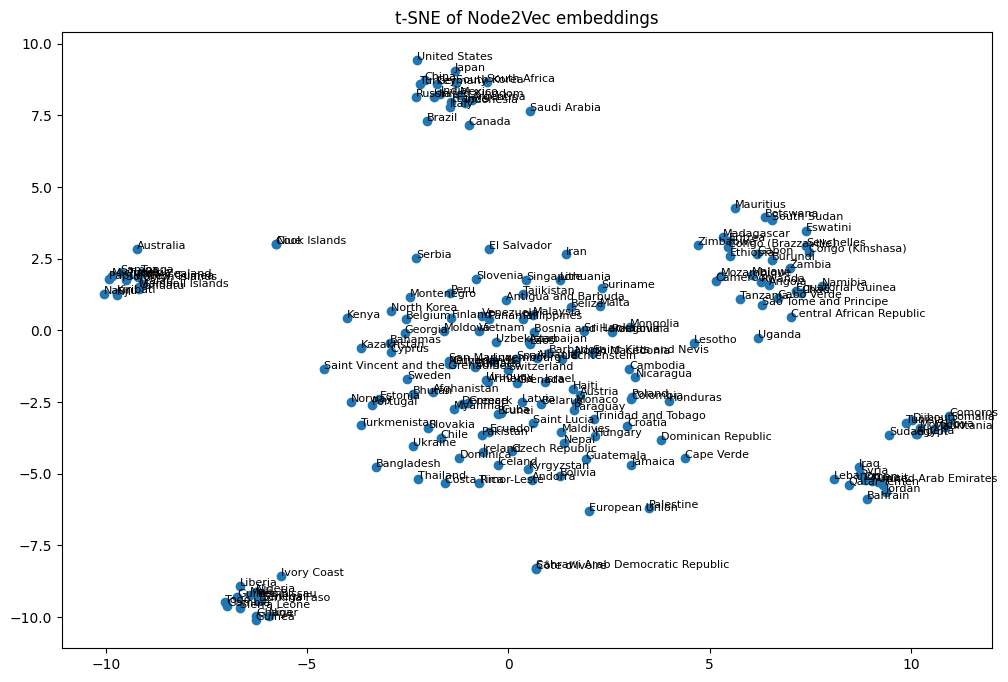

In [40]:
from sklearn.manifold import TSNE

vecs = np.array([model.wv[country] for country in model.wv.index_to_key])
labels = model.wv.index_to_key

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(vecs)

plt.figure(figsize=(12, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])

for i, label in enumerate(labels):
    plt.annotate(label, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

plt.title("t-SNE of Node2Vec embeddings")
plt.show()

In [13]:
import pandas as pd
import networkx as nx
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
import random

def plot_country_IGO(num: int):
    country_igos = {}
    for _, row in IGO.iterrows():
        for country in row["Member Countries"]:
            if country not in country_igos:
                country_igos[country] = []
            country_igos[country].append(row["IGO Name"])
    
    shared_igos = {}
    countries = list(country_igos.keys())
    for c1, c2 in combinations(countries, 2):
        common_igos = set(country_igos[c1]) & set(country_igos[c2])
        shared_igos[(c1, c2)] = len(common_igos)
        shared_igos[(c2, c1)] = len(common_igos)
    
    G_weighted = nx.Graph()
    for (c1, c2), weight in shared_igos.items():
        if weight > 0:
            G_weighted.add_edge(c1, c2, weight=weight)
    
    selected_countries = random.sample(countries, num)
    
    adj_matrix = nx.to_numpy_array(G_weighted, nodelist=selected_countries, weight="weight")
    adj_df = pd.DataFrame(adj_matrix, index=selected_countries, columns=selected_countries)
    plt.figure(figsize=(15, 12))
    sns.heatmap(
        adj_df,
        cmap="YlOrRd",
        square=True,
        linewidths=0.3,
        annot=True,
        cbar_kws={"label": "Number of Shared IGOs"},
    )
    
    plt.title("Number of Shared IGO Memberships (30 Random Countries)", fontsize=16)
    plt.xlabel("Country", fontsize=12)
    plt.ylabel("Country", fontsize=12)
    plt.xticks(rotation=90, fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.show()

def get_organizations(country: str):
    return [igo for igo, members in organizations.items() if country in members]

In [14]:
df = df.drop(columns=['Holy See (Vatican City State)', 'Congo', 'Czechia', 'Congo, The Democratic Republic of the'])
df = df.rename(columns={'Viet Nam': 'Vietnam', 'Brunei Darussalam': 'Brunei','Iran, Islamic Republic of': 'Iran',"Lao People's Democratic Republic": 'Laos','Türkiye': 'Turkey','Syrian Arab Republic': 'Syria','Russian Federation': 'Russia', 'Palestine, State of': 'Palestine', 'Korea, Republic of': 'South Korea', "Korea, Democratic People's Republic of": 'North Korea', 'Bolivia, Plurinational State of': 'Bolivia', 'Moldova, Republic of': 'Moldova', 'Tanzania, United Republic of': 'Tanzania', 'Micronesia, Federated States of':'Micronesia', 'Venezuela, Bolivarian Republic of': 'Venezuela'})
for i in df.columns:
    if not i in list(model.wv.key_to_index.keys()):
        print(i)

In [15]:
#df = df.drop(columns=['Bolivia, Plurinational State of', 'Brunei Darussalam'])
countries = list(df.columns)
graph_data = []
speech_data = []
for country in countries:
    graph_data.append(list(model.wv[country]))
    speech_data.append(list(df[country]))

speech_data = np.array(speech_data)
graph_data = np.array(graph_data)

# Combining speech embeddings and knowledge based embeddings

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Epoch 1, Loss: 815.852722
Epoch 50, Loss: 0.820265
MSE between Euclidean distance matrices: 0.18424217842885893


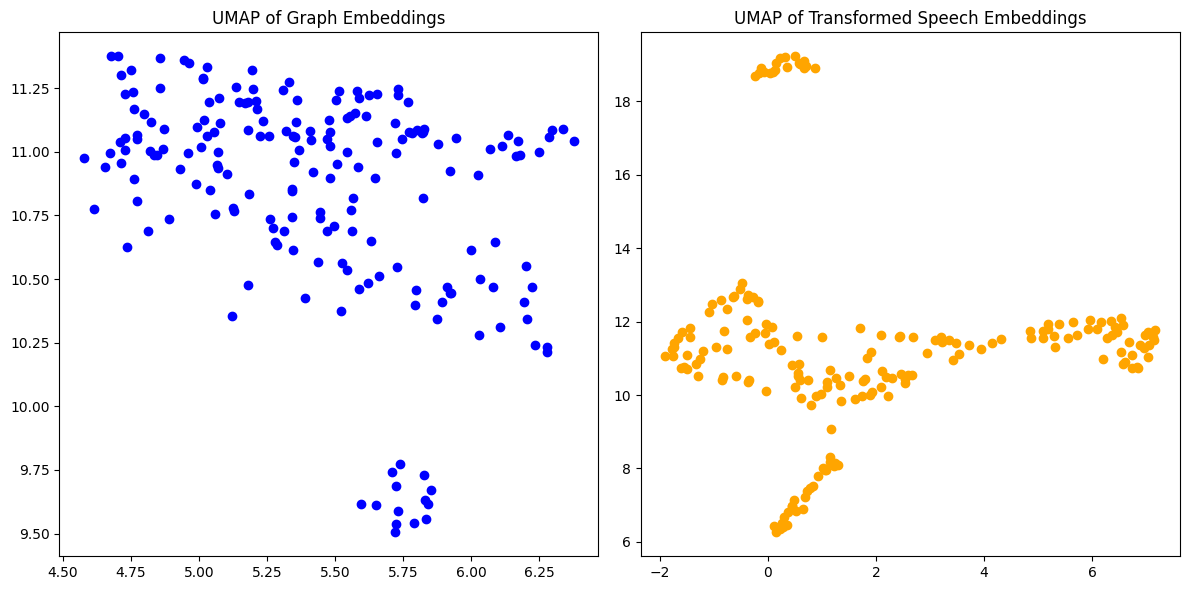

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import umap
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# --- 1. Define Model ---
class VectorInjector(nn.Module):
    def __init__(self, dim=512, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, dim)

    def forward(self, x):
        h = F.relu(self.bn1(self.fc1(x)))
        h = F.relu(self.bn2(self.fc2(h)))
        out = self.fc3(h) + x  # Residual connection
        return out

# --- 2. Distance Matrix Function (Euclidean) ---
def euclidean_distance_matrix(vectors):
    return torch.cdist(vectors, vectors, p=2)  # shape (N x N)

# --- 3. Matrix Loss Function ---
def matrix_distance_loss(pred_vectors, target_matrix):
    pred_dists = euclidean_distance_matrix(pred_vectors)
    return F.mse_loss(pred_dists, target_matrix)

# --- 4. Train Function ---
def train_to_match_umap_geometry(speech_data, graph_data, umap_dim=10, epochs=50, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Step 1: Compute UMAP of graph embeddings
    graph_umap = umap.UMAP(n_components=umap_dim, random_state=42).fit_transform(graph_data)

    # Step 2: Compute pairwise Euclidean distances in UMAP space
    with torch.no_grad():
        umap_dists = squareform(pdist(graph_umap, metric='euclidean'))
        A = torch.tensor(umap_dists, dtype=torch.float32).to(device)

    # Step 3: Prepare input
    speech_tensor = torch.from_numpy(speech_data).float().to(device)

    # Step 4: Initialize model
    model = VectorInjector(dim=speech_data.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Step 5: Training loop
    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        transformed = model(speech_tensor)
        loss = matrix_distance_loss(transformed, A)
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0 or epoch == 1:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    return model, graph_umap

# --- 5. Get Transformed Embeddings ---
def get_transformed_embeddings(model, speech_data):
    model.eval()
    with torch.no_grad():
        device = next(model.parameters()).device
        input_tensor = torch.from_numpy(speech_data).float().to(device)
        output_tensor = model(input_tensor)
    return output_tensor.cpu().numpy()

# --- 6. Evaluation Utility ---
def matrix_distance(A, B):
    return np.mean((A - B) ** 2)

def print_similarity_quality(transformed, graph_umap):
    ts = transformed / np.linalg.norm(transformed, axis=1, keepdims=True)
    gu = graph_umap / np.linalg.norm(graph_umap, axis=1, keepdims=True)
    dist_ts = squareform(pdist(ts, 'euclidean'))
    dist_gu = squareform(pdist(gu, 'euclidean'))
    print("MSE between Euclidean distance matrices:", matrix_distance(dist_ts, dist_gu))

# === RUN TRAINING ===
# Replace these with your actual numpy arrays (N x D)
# speech_data = np.array(...)    # shape: (num_countries, speech_dim)
# graph_data = np.array(...)     # shape: (num_countries, graph_dim)

trained_model, graph_umap = train_to_match_umap_geometry(speech_data, graph_data)
transformed_speech = get_transformed_embeddings(trained_model, speech_data)
print_similarity_quality(transformed_speech, graph_umap)

# Optional: Visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("UMAP of Graph Embeddings")
plt.scatter(graph_umap[:, 0], graph_umap[:, 1], c='blue')

tsne = umap.UMAP(n_components=2).fit_transform(transformed_speech)
plt.subplot(1, 2, 2)
plt.title("UMAP of Transformed Speech Embeddings")
plt.scatter(tsne[:, 0], tsne[:, 1], c='orange')
plt.tight_layout()
plt.show()

In [57]:
combined_embedding = torch.reshape(torch.tensor(transformed_speech), (4096, 190))

np_array = combined_embedding.detach().cpu().numpy()
final_country_embeddings = pd.DataFrame(np_array, columns=countries)
final_country_embeddings

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,0.082718,0.009589,-0.064192,-0.000372,0.010512,-0.007637,0.016842,0.002520,-0.037363,0.040755,...,0.059830,0.001992,0.000356,-0.048068,-0.023446,-0.019163,0.074659,-0.013563,-0.045675,0.079637
1,0.058424,-0.069293,-0.068272,-0.013735,0.070286,-0.053675,-0.069152,0.040164,0.059451,0.022373,...,-0.022072,-0.034395,0.029083,-0.017559,-0.065505,-0.040957,0.019488,0.017598,0.086784,-0.057704
2,-0.113160,-0.042305,0.016042,-0.051069,-0.056953,-0.117006,0.006710,-0.065439,-0.061005,-0.135475,...,0.047782,-0.015863,-0.003805,-0.043396,0.051990,-0.029337,-0.015967,-0.029252,-0.005563,-0.027005
3,0.031239,0.070786,0.103193,-0.037741,0.039801,-0.107983,0.078743,-0.015746,-0.033782,-0.039203,...,-0.002452,0.018381,0.057037,-0.015796,0.039599,0.038862,0.067179,-0.000109,-0.041832,0.075317
4,0.009214,-0.041799,-0.021127,-0.028889,0.027874,0.014207,0.009322,0.010730,-0.025281,0.044044,...,-0.041440,0.021012,-0.059611,-0.042942,-0.008135,0.115409,0.063805,-0.077536,0.067966,-0.004749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,-0.005414,0.003052,-0.043230,-0.080624,-0.007308,0.043804,0.042369,0.029895,0.038230,-0.050502,...,-0.080899,-0.019431,0.065085,0.022477,-0.062520,-0.107382,0.062307,-0.005144,-0.033543,-0.036488
4092,-0.007616,0.075616,0.055754,0.014285,-0.039540,-0.077601,-0.034681,0.038648,0.024527,-0.014986,...,0.001973,-0.022212,-0.065594,-0.011575,-0.062581,0.004761,-0.025727,-0.027132,0.031823,-0.005614
4093,-0.042564,0.017477,0.031242,-0.098347,0.049907,0.018031,-0.049781,-0.057341,-0.099995,-0.005996,...,0.013048,-0.015381,-0.024890,0.022313,-0.080512,-0.007772,-0.010492,0.011519,0.021146,-0.004771
4094,0.021993,0.112961,0.049622,0.079424,-0.041218,0.006093,-0.063639,-0.047177,-0.009299,-0.066976,...,0.007592,-0.019732,0.088094,-0.040152,0.004086,0.030693,0.003598,0.003098,0.021498,0.146830


In [21]:
def get_av_embedding(speech: str):
    clean_speech = clean_text(speech)
    segments = get_segments(clean_speech)
    embeddings = generate_embeddings(segments)
    vec = np.array(embeddings)
    return np.mean(vec, axis=0)

Text(0.5, 1.0, 'Correlation Between Policy - Speech Embeddings')

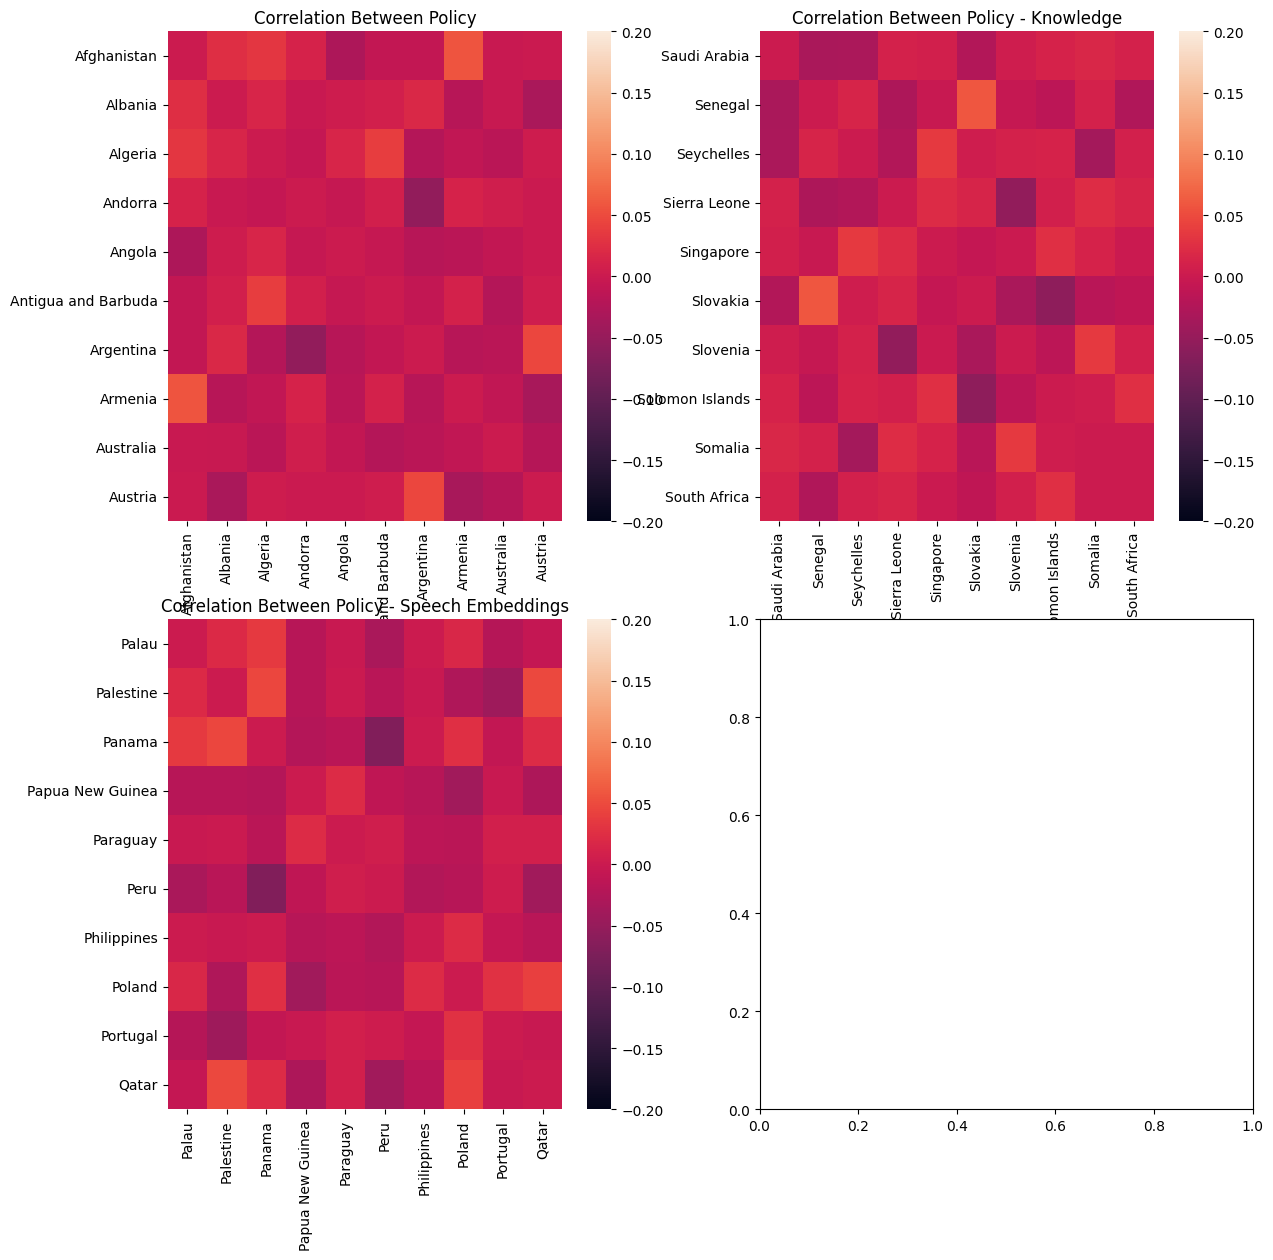

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

import random
def get_corr_matrix(final_country_embeddings):
    start = random.randint(0, len(final_country_embeddings.columns)-10)
    corr_matrix = pd.DataFrame(
        index=final_country_embeddings.columns[start:start+10],
        columns=final_country_embeddings.columns[start:start+10],
        dtype=float
    )
    for i, country in enumerate(final_country_embeddings.columns[start:start+10]):
        for j, country_2 in enumerate(final_country_embeddings.columns[start:start+10]):
            if j > i:
                sim = compare_countries(country, country_2)
                corr_matrix.loc[country, country_2] = sim
                corr_matrix.loc[country_2, country] = sim
            elif j==i:
                corr_matrix.loc[country, country_2] = 0
    return corr_matrix

corr_matrix = get_corr_matrix(final_country_embeddings)
graph_data = np.array(graph_data)
speech_data = np.array(speech_data)
print(graph_data.shape, speech_data.shape)

graph_df = pd.DataFrame(graph_data.transpose(), columns=countries)
speech_df = pd.DataFrame(speech_data.transpose(), columns=countries)

graph_df = get_corr_matrix(graph_df)
speech_df = get_corr_matrix(speech_df)

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

minmax = 0.2

sns.heatmap(corr_matrix, annot=False, vmin=-minmax, vmax=minmax, ax=axes[0])
axes[0].set_title('Correlation Between Policy')

sns.heatmap(graph_df, annot=False, vmin=-minmax, vmax=minmax, ax=axes[1])
axes[1].set_title('Correlation Between Policy - Knowledge')

sns.heatmap(speech_df, annot=False, vmin=-minmax, vmax=minmax, ax=axes[2])
axes[2].set_title('Correlation Between Policy - Speech Embeddings')

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0.5, 1.0, 'UMAP Distance Between Country Policy Embeddings')

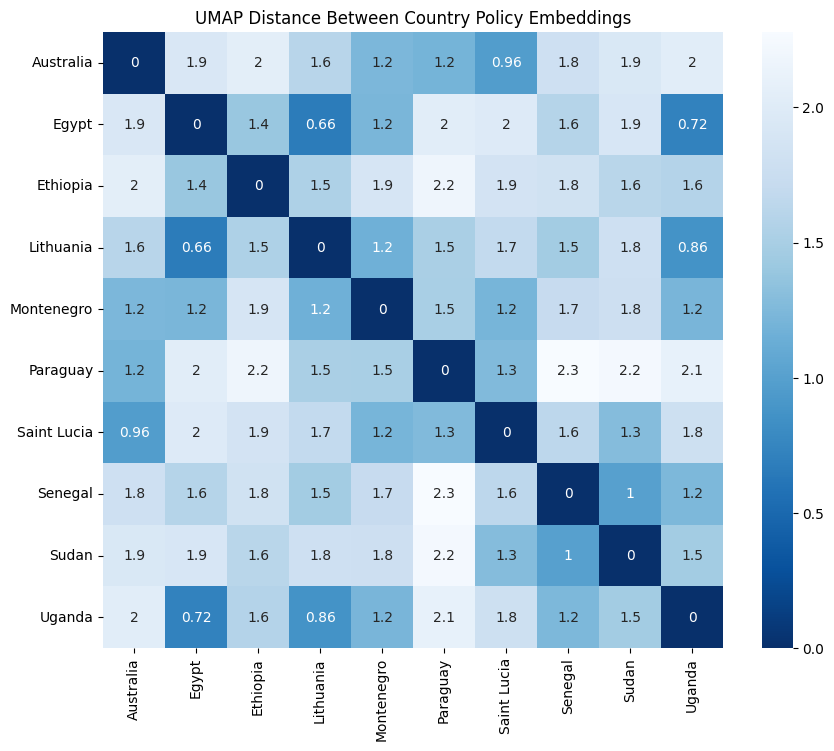

In [78]:
import umap
plt.figure(figsize=(10,8))

umap_model = umap.UMAP(n_components=5, random_state=42)
graph_umap = umap_model.fit_transform(graph_data)
speech_umap = umap_model.fit_transform(final_country_embeddings)

from scipy.spatial.distance import pdist, squareform

def get_distance_matrix(umap_embeddings, countries, sample_size=10):
    idx = sorted(random.sample(range(len(countries)), sample_size))
    selected = umap_embeddings[idx]
    dist_matrix = squareform(pdist(selected, metric='euclidean'))
    selected_countries = [countries[i] for i in idx]
    df = pd.DataFrame(dist_matrix, index=selected_countries, columns=selected_countries)
    return df
graph_umap_df = get_distance_matrix(graph_umap, countries)
speech_umap_df = get_distance_matrix(speech_umap, countries)

sns.heatmap(speech_umap_df, annot=True, vmin=0, vmax=None, cmap="Blues_r")
plt.title('UMAP Distance Between Country Policy Embeddings')

In [69]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def generate_country_similarity(speech: str, place: str):
    or_encode = np.array(generate_embeddings([speech])[0])
    vec = np.array(embeddings)
    av_vec = np.mean(vec, axis=0)
    topic_consistency = cosine_similarity(av_vec.reshape(1, -1), or_encode.reshape(1, -1))[0][0]
    print(f"Topic consistency: {topic_consistency}")

    av_vec = np.expand_dims(av_vec, axis=0)
    with torch.no_grad():
        av_vec = get_transformed_embeddings(trained_model, av_vec)
    
    lis = []
    for column in final_country_embeddings.columns:
        cs = cosine_similarity(
            av_vec,
            np.array(list(final_country_embeddings[column])).reshape(1, -1)
        )
        lis.append((cs[0][0], column))
    sorted_data = sorted(lis, key=lambda x: x[0], reverse=True)
    for score, country in sorted_data:
        if country == place:
            print(f'\n\n-----{country}------\n\n')
            print(f"{score:.8f} — {country}")
            print('\n\n')
        else:
            print(f"{score:.8f} — {country}")
def compare_countries(country1, country2):
    cs = cosine_similarity(
        np.array(list(final_country_embeddings[country1])).reshape(1, -1),
        np.array(list(final_country_embeddings[country2])).reshape(1, -1)
    )
    return cs

In [72]:
import random
MUN_speeches = pd.read_csv("/kaggle/input/mun-speech-dataset/MUN Speech Testing.csv")
index = random.randint(0, len(MUN_speeches)-1)
print(index)
generate_country_similarity(MUN_speeches.loc[index]['Speech'], MUN_speeches.loc[index]['Country'])

3
Topic consistency: 0.4245967341877029
0.03546242 — Seychelles
0.03502922 — Jordan
0.03215255 — Equatorial Guinea
0.03131625 — Indonesia
0.03108643 — United Kingdom
0.03106381 — Jamaica
0.03079089 — Peru
0.03076294 — Latvia
0.03031710 — Comoros
0.02941448 — Germany
0.02936163 — Belgium
0.02883650 — Senegal
0.02700813 — Yemen
0.02699987 — Togo
0.02569560 — Ecuador
0.02545383 — Brazil
0.02489409 — Zimbabwe
0.02468597 — Libya
0.02210736 — Panama
0.02149212 — Laos
0.02094930 — Bahrain
0.02082366 — Greece
0.02046675 — Somalia
0.02021775 — Cabo Verde
0.02017526 — Armenia
0.02002944 — Cuba
0.01999583 — Kuwait
0.01988496 — Guyana
0.01959595 — Mali
0.01941140 — Ghana
0.01897978 — Colombia
0.01878727 — Tunisia
0.01856322 — Zambia
0.01816411 — Iran
0.01799848 — Venezuela
0.01754773 — Philippines
0.01754116 — Vanuatu
0.01732610 — Benin
0.01716278 — Hungary
0.01704649 — Moldova
0.01673841 — Iraq
0.01638615 — Cyprus
0.01636970 — India
0.01626887 — China
0.01618660 — Bosnia and Herzegovina
0.0161287